<font size = 6>Исследования рынка общепита в Москве для принятия решения об открытии нового заведения</font>

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

**План исследования:**
* Cоотношение видов объектов общественного питания по количеству;
* Соотношение сетевых и несетевых заведений по количеству;
* Особенности сетевых заведений;
* Среднее количество посадочных мест по категориям объектов;
* Топ-10 улиц по количеству объектов общественного питания;
* Районы Москвы для Топ-10 улиц;
* Улицы с одним объектом общественного питания. Распределение по районам;
* Распределение количества посадочных мест для топ-10 улиц.

**Описание данных**  
Таблица rest_data:
- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.


# Загрузка данных

Импортиреум необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import numpy as np
from tqdm import tqdm

In [2]:
# передаем переменной data значения файла данных типа .csv 
# добавим варианты расмоложения файла данных, локальный ПК или ссылка на Практикуме
try:
    data = pd.read_csv('rest_data.csv')
except FileNotFoundError as e:
    print(e)
    data = pd.read_csv('***/rest_data.csv')

In [3]:
# проверка
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
# общая информация по df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Описание данных**
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

Вывод: Исходные данные содержат 6 колонок для 15366 строк. Пропуски отсутствуют. Замечаний по форматам данных нет.

# Поверка и подготовка данных

Проверим наличие дубликатов

In [5]:
data.duplicated().sum()

0

Дубликаты отсутствуют

Проверим уникальные записи по 'id'

In [6]:
data['id'].nunique()

15366

Все 15366 значений уникальны, повторов нет

Проверим уникальные записи по 'chain'

In [7]:
data['chain'].unique()

array(['нет', 'да'], dtype=object)

Только 2 значения булевого типа

Проверим уникальные записи по 'object_type'

In [8]:
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Имеем 9 категорий, явных повторений не выявлено

Оценим значения 'number'

In [9]:
data['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [10]:
data.query('number == 0')['object_type'].value_counts().to_frame()

,object_type
предприятие быстрого обслуживания,704
кафе,310
закусочная,189
магазин (отдел кулинарии),145
кафетерий,113
буфет,68
ресторан,45
бар,28
столовая,19


Явных ошибок не выявлено. Нулевое количество посадочных мест может иметь место, например, для категории "магазин (отдел кулинарии)". Более подробнее рассмотрим данные при анализе.

# Анализ данных

## Cоотношение типов объектов общественного питания

In [11]:
# создадим df с количество объектов по типу
obj_sorted = data['object_type'].value_counts().to_frame().reset_index()
# переименуюм столбцы
obj_sorted.columns = ['object_type', 'qty']
# порядок сохрония в переменную
order = obj_sorted['object_type'].to_list()
# посмотрим на результат
obj_sorted

,object_type,qty
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


In [12]:
# добавим столбец с долями
obj_sorted['ratio'] = (obj_sorted['qty']/obj_sorted['qty'].sum()).map('{:.2%}'.format)
obj_sorted

,object_type,qty,ratio
0,кафе,6099,39.69%
1,столовая,2587,16.84%
2,ресторан,2285,14.87%
3,предприятие быстрого обслуживания,1923,12.51%
4,бар,856,5.57%
5,буфет,585,3.81%
6,кафетерий,398,2.59%
7,закусочная,360,2.34%
8,магазин (отдел кулинарии),273,1.78%


In [13]:
# задаём размер графика
sns.set(rc={'figure.figsize':(15,5)})

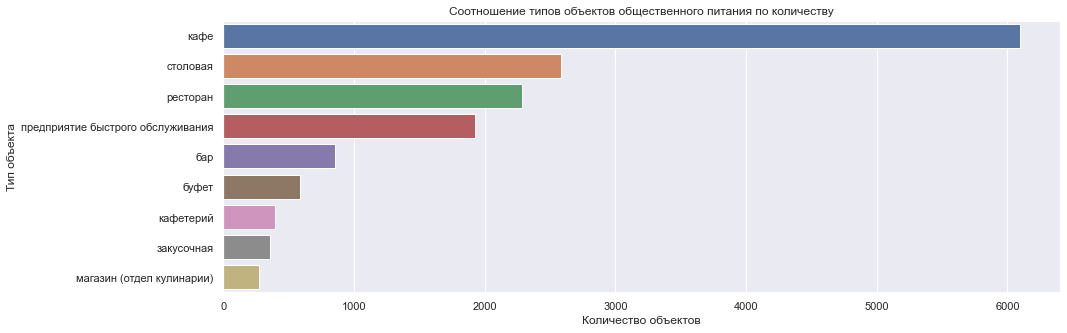

In [14]:
# Визуализируем полученные данные
sns.barplot(y='object_type', x='qty', data=obj_sorted)\
    .set(title = 'Cоотношение типов объектов общественного питания по количеству',
         xlabel = 'Количество объектов',
         ylabel = 'Тип объекта',
         )
plt.show()

В данных преобладают объекты типа "кафе", которые составляют почти 40% от общего числа.  
Так же, можно отметить, что первые четыре вида объектов составляют более 83% от общего числа.

## Общее соотношение сетевых и несетевых заведений.

In [15]:
# создадим df с количество объектов по виду сетевой/несетевой
chain_obj = data['chain'].value_counts().to_frame().reset_index()
chain_obj.columns = ['chain', 'qty']
chain_obj

,chain,qty
0,нет,12398
1,да,2968


In [16]:
# Общее число объектов для расчёта долей
total_obj = chain_obj['qty'].sum()

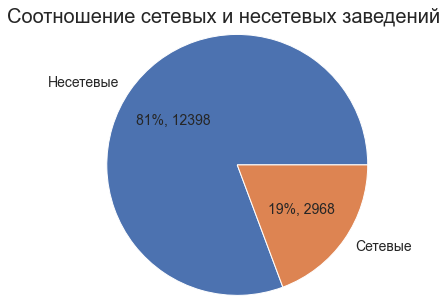

In [17]:
plt.figtext(.5,.9,'Cоотношение сетевых и несетевых заведений', fontsize=20, ha='center')
plt.pie(chain_obj['qty'].to_list(), labels=['Несетевые', 'Сетевые'],\
        autopct=lambda p:f'{p:.0f}%, {p*total_obj/100 :.0f}', textprops={'fontsize': 14}, radius = 1.2)

plt.show()

Явное преобладпние несетевых объектов.

## Сетевые и несетевые объекты для каждого типа.

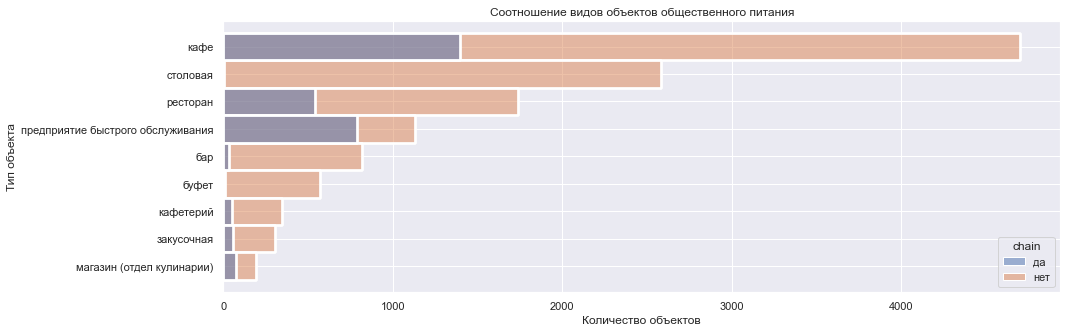

In [18]:
# Построим гистограмму, упорядочив по общему количеству объектов
df = data
df['object_type'] = pd.Categorical(df['object_type'], order)
sns.histplot(y='object_type', data=df, hue='chain', hue_order = ['да', 'нет'])\
     .set(title = 'Cоотношение видов объектов общественного питания',
          xlabel = 'Количество объектов',
          ylabel = 'Тип объекта',
          )
plt.show()

Объекты типа столовая и буфет почти полностью относятся к несетевым объектам. Сетевой тип наиболее распространён среди предприятий быстрого обслуживания, таких там около двух третей. Также стоит отметить, что при незначительном общем числе, почти половина кулинарий принадлежат сетевым магазинам. Доли сетевых заведений для кафе и ресторанов, примерно одинаковые 25-30%.

## Особенности сетевых заведений.

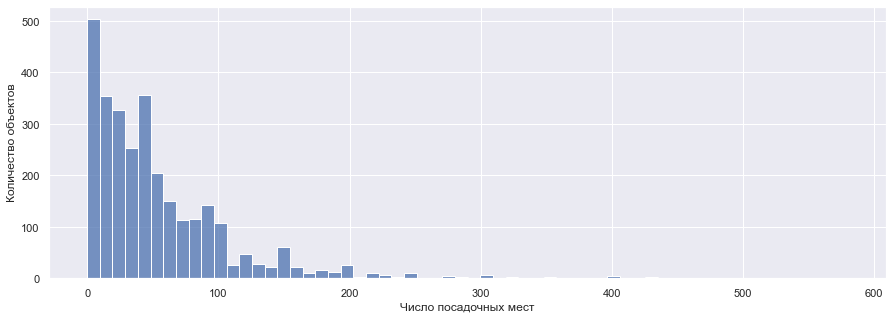

In [19]:
# Распределиние числа посадочных мест для сетевых заведений
sns.histplot(x="number", data=data.query('chain == "да"'), bins=60)\
    .set(title = '',
          xlabel = 'Число посадочных мест',
          ylabel = 'Количество объектов')
plt.show() #

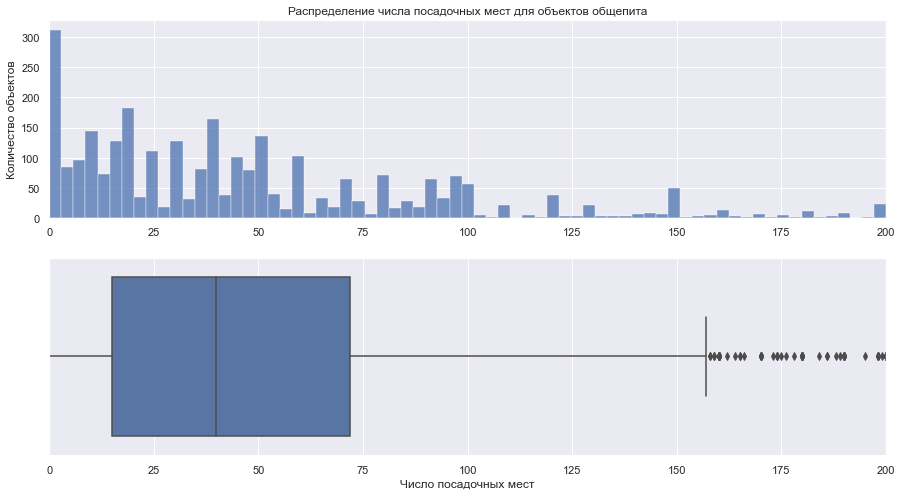

In [20]:
# Укрупним часть гистограммы с числом посадочных мест от 0 до 200
# Для нагладности добавим BoxPlot

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

sns.histplot(x="number", data=data.query('chain == "да"'), bins=200, ax=ax1)\
    .set(title = 'Распределение числа посадочных мест для объектов общепита',
          xlabel = '',
          ylabel = 'Количество объектов',
          xlim=(0, 200))

sns.boxplot(x='number', data=data.query('chain == "да"'), ax=ax2)\
    .set(title = '',
          xlabel = 'Число посадочных мест',
          ylabel = '',
          xlim=(0, 200)
          )
plt.show()

Снова отмечаем большое количество (более 300) объектов с нулевым количеством посадочных мест. В целом, имеем большое количество объектов с числом посадочных мест до 70. Медианное значение около 40.  
Для справки, сравним эти харектеристики с характеристиками объектов за вычитом тех, для которых number = 0.

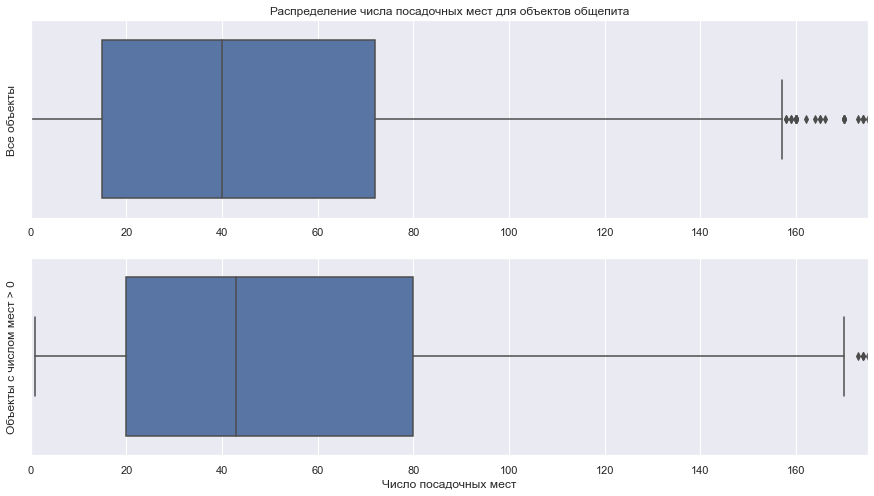

In [21]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

sns.boxplot(x='number', data=data.query('chain == "да"'), ax=ax1)\
    .set(title = 'Распределение числа посадочных мест для объектов общепита',
          xlabel = '',
          ylabel = 'Все объекты',
          xlim=(0, 175))

sns.boxplot(x='number', data=data.query('chain == "да" and number !=0'), ax=ax2)\
    .set(title = '',
          xlabel = 'Число посадочных мест',
          ylabel = 'Oбъекты с числом мест > 0',
          xlim=(0, 175)
          )
plt.show()

Можно сказать, что влияние незначительно. Есть сдвиг 1-го и 3-го квартилей на 5-7 единиц. Сдвиг медианы 3-4 единицы. 

## Среднее количество посадочных мест по категориям объектов.

Для каждого из типов объектов получим:
- общее число объектов
- общее число посадочных мест
- минимальное число посадочных мест
- максимальное число посадочных мест
- среднее число посадочных мест
- медиану посадочных мест

In [22]:
av_numbers = (data.groupby('object_type').agg({'number':['count', 'sum', 'min', 'max', 'mean', 'median']})
              .sort_values(by=('number',  'mean'), ascending=False)
              .reset_index()
             )
av_numbers[('number', 'mean')] = round(av_numbers[('number', 'mean')], 2)
av_numbers

object_type number                                 
                                      count     sum min   max    mean median
0                           столовая   2587  336948   0  1400  130.25    103
1                           ресторан   2285  221266   0  1500   96.83     80
2                              буфет    585   29911   0   320   51.13     32
3                                бар    856   37231   0  1700   43.49     35
4                               кафе   6099  242228   0   533   39.72     30
5  предприятие быстрого обслуживания   1923   39522   0   580   20.55      5
6                          кафетерий    398    3631   0   200    9.12      6
7                         закусочная    360    2739   0   216    7.61      0
8          магазин (отдел кулинарии)    273    1526   0    50    5.59      0

Отметим, что судя по медианным значениям для четырёх последних типов, доля объектов с числом посадочных мест равным нулю велика. 

Для наглядности построим Boxplot

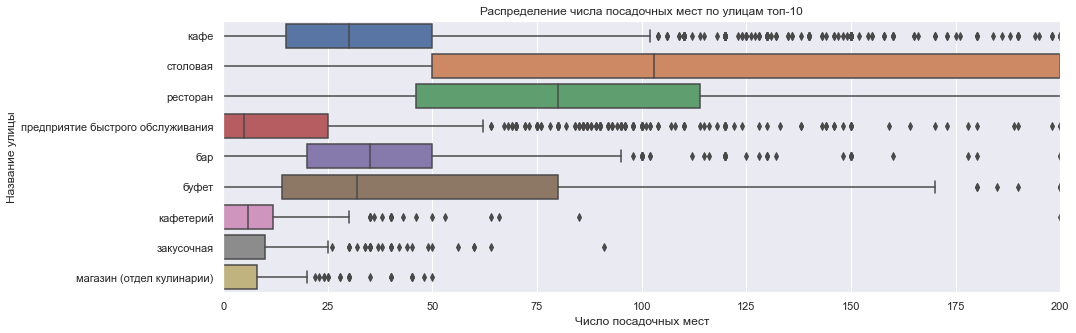

In [23]:
sns.boxplot(x='number', y='object_type', data=data)\
    .set(title = 'Распределение числа посадочных мест по улицам топ-10',
          xlabel = 'Число посадочных мест',
          ylabel = 'Название улицы',
         xlim = (0,200)
        )
plt.show()

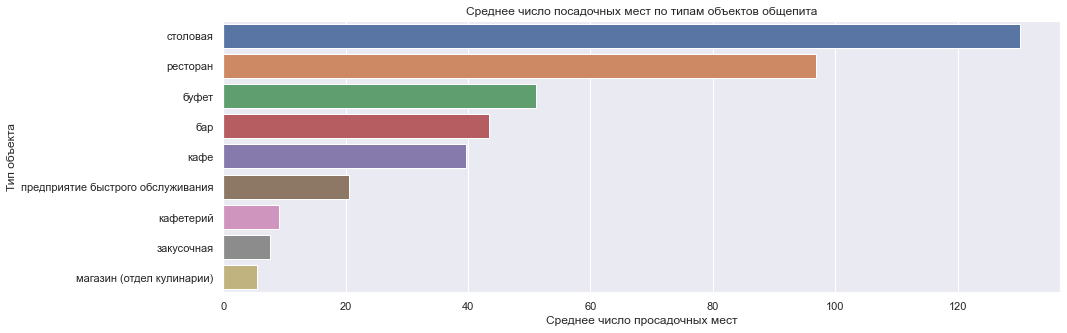

In [24]:
# Cреднее число посадочных мест по типам объектов
av_numbers[('object_type', '')] = pd.Categorical(av_numbers[('object_type', '')], av_numbers[('object_type', '')].to_list())
sns.barplot(y=('object_type', ''), x=('number', 'mean'), data=av_numbers)\
    .set(title = 'Cреднее число посадочных мест по типам объектов общепита',
         xlabel = 'Среднее число просадочных мест',
         ylabel = 'Тип объекта',
         )
plt.show()

По среднему числу посадочных мест явными лидерами являются столовые и рестораны. Кафетерии, зекусочные и отделы кулинарии в аутсайдерах. 

In [25]:
# Посмотрим на объекты с нулевым числом посадочных мест по категориям
data.query('number == 0')['object_type'].value_counts().to_frame()

,object_type
предприятие быстрого обслуживания,704
кафе,310
закусочная,189
магазин (отдел кулинарии),145
кафетерий,113
буфет,68
ресторан,45
бар,28
столовая,19


In [26]:
# Посмотрим на категорию 'ресторан' с нулевым числом посадочных мест
data.loc[(data['number'] == 0) & (data['object_type'] == 'ресторан')]

,id,object_name,chain,object_type,address,number
1873,79718,Макдоналдс,да,ресторан,"город Москва, поселение Московский, деревня Го...",0
4490,152298,Фудмаркет. Яшечкина,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4491,152299,Фудмаркет. Грачева,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4492,152305,Фудмаркет. Шапиро,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4493,152307,Фудмаркет. Салпагарова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4501,152255,Фудмаркет.Швыдкой,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4502,152222,Фудмаркет.Паритова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4503,152224,Фудмаркет. Рогачикова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4504,152216,Фудмаркет. Галичкин,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
6113,27193,МАКСИМАЛЬНЫЙ РЕСТОРАН,нет,ресторан,"город Москва, Профсоюзная улица, дом 61А",0


In [27]:
# Сгруппируем по адресам
data.loc[(data['number'] == 0) & (data['object_type'] == 'ресторан')]['address'].value_counts().to_frame()

,address
"город Москва, Профсоюзная улица, дом 61А",10
"город Москва, улица Новый Арбат, дом 21",8
"город Москва, Хорошёвское шоссе, дом 27",5
"город Москва, улица Вавилова, дом 3",5
"город Москва, Ходынский бульвар, дом 4",5
"город Москва, Автозаводская улица, дом 18",2
"город Москва, город Московский, улица Хабарова, дом 2",2
"город Москва, Кутузовский проспект, дом 57",1
"город Москва, поселение Московский, деревня Говорово, дом 1Б/Н",1
"город Москва, улица 8 Марта, дом 8, корпус 1",1


Видим, что много рестораров имеют один адрес. Возможно рестараны расположены на фуд-кортах ТЦ и имеют общий зал. Например, город Москва, Профсоюзная улица, дом 61А это ТЦ "Калужский"

## Выделение информациюи об улице.

Посмотрим на уникальные значения первой позиции (до первой ",") в столбце 'address'

In [28]:
data['address'].apply(lambda x: x.split(', ')[0]).unique()

array(['город Москва', 'Партизанская улица', 'Поречная улица',
       '1-й Нагатинский проезд', 'Софийская набережная',
       'Нижний Таганский тупик', 'Николоямская улица', 'улица Каманина',
       'Погодинская улица', 'Большая Бронная улица',
       '2-я Брестская улица', 'Профсоюзная улица', 'Калашный переулок',
       'Солянский тупик', 'улица Земляной Вал', 'Таганская площадь',
       'проезд Добролюбова', 'улица Обручева', 'Вспольный переулок',
       'улица Ленинская Слобода', 'Дербеневская улица',
       'Проектируемый проезд N 5231', 'Ленинский проспект',
       'Новоданиловская набережная', '5-й Котельнический переулок',
       'улица Знаменка', 'Школьная улица', 'поселение Сосенское',
       'Полевая улица', 'поселение Марушкинское',
       'поселение Михайлово-Ярцевское', 'город Московский',
       'Митинская улица', 'Чертановская улица', 'Варшавское шоссе',
       'улица Миклухо-Маклая', '1-я Тверская-Ямская улица',
       'Краснобогатырская улица', 'город Троицк', 'Медын

Применим функцию для выбеления названия улицы из адреса указанного в 'address'

In [29]:
def street_name(full_adress):
    # строку преобразуем в список по разделителю ', '
    sp_address = full_adress.split(', ')
    # если у первого по счёту этемента списка, на первой позиции указано 'город', 
    # то возвращаем следующий элемент в качестве названия улицы 
    if sp_address[0].split(' ')[0] == 'город': return sp_address[1]
    # если условие не выполняется, во возвращаем первый элемент в качестве названия улицы 
    else: return sp_address[0]

In [30]:
data['street'] = data['address'].apply(street_name)
data.sample(5)

,id,object_name,chain,object_type,address,number,street
9197,162615,Столовая,нет,столовая,"город Москва, поселение Щаповское, посёлок Кур...",96,поселение Щаповское
5838,28320,КАФЕ,нет,кафе,"город Москва, Ферганская улица, дом 23",60,Ферганская улица
11924,187341,Суши Сет,да,магазин (отдел кулинарии),"город Москва, Щёлковское шоссе, дом 60",0,Щёлковское шоссе
9314,167185,Ла Карта,нет,ресторан,"город Москва, Херсонская улица, дом 43",78,Херсонская улица
10269,188538,ОРИГАМИ СУШИ-РОЛЛЫ,нет,кафе,"город Москва, улица Декабристов, дом 21",10,улица Декабристов


## Топ-10 улиц по количеству объектов общественного питания.

In [31]:
# Топ-10 улиц
data['street'].value_counts().to_frame().reset_index().head(10)

,index,street
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,183
3,Ленинградский проспект,173
4,Пресненская набережная,167
5,Варшавское шоссе,162
6,Ленинский проспект,148
7,поселение Сосенское,139
8,проспект Вернадского,132
9,Кутузовский проспект,114


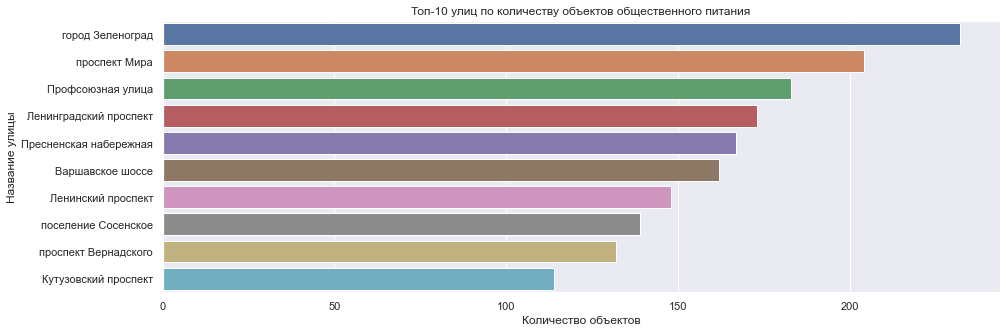

In [32]:
sns.barplot(x='street', y='index', data=data['street'].value_counts().to_frame().reset_index().head(10))\
    .set(title = 'Топ-10 улиц по количеству объектов общественного питания',
        xlabel = 'Количество объектов',
        ylabel = 'Название улицы',
        )
plt.show()

В Топ-10, помимо улиц, попали и более крупные территориальные единицы: город Зеленоград, поселение Сосенское. Это довольно крупные районы, орасположенные за границ старой Москвы (МКАД).  

Зеленоград - город в России, образующий один из 12 административных округов Москвы. Расположен в 37 км к северо-западу от центра Москвы. Один из трёх округов, которые были образованы на территориях, полностью находящихся за пределами Московской кольцевой автомобильной дороги.

Поселение Сосенское — внутригородское муниципальное образование и административная единица со статусом поселения в составе Новомосковского административного округа Москвы. 

В указанных районах расположены улицы и кварталы. В связи с этим, будет некорректно проводить сравнение и данные по этим районам исключим из топ-10, ограничив выборку Москвой в границах МКАД.

In [33]:
dt1 = (
    data.loc[(data['street'] != 'город Зеленоград') & (data['street'] != 'поселение Сосенское')]['street']
    .value_counts()
    .to_frame()
    .reset_index()
    .head(10)
    )
dt1

,index,street
0,проспект Мира,204
1,Профсоюзная улица,183
2,Ленинградский проспект,173
3,Пресненская набережная,167
4,Варшавское шоссе,162
5,Ленинский проспект,148
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


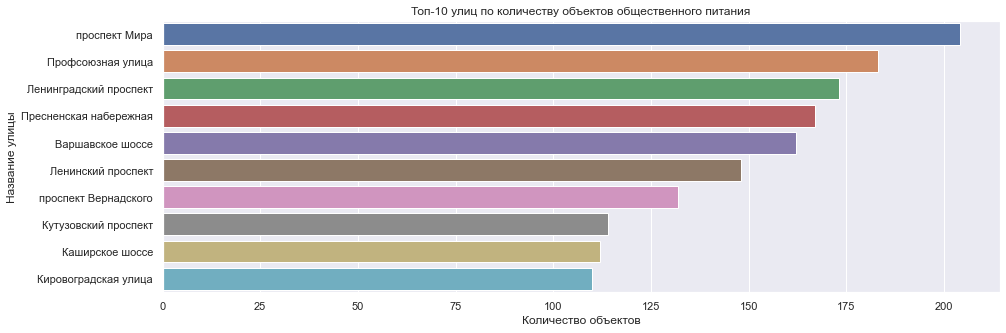

In [34]:
sns.barplot(x='street', y='index', data=dt1)\
    .set(title = 'Топ-10 улиц по количеству объектов общественного питания',
          xlabel = 'Количество объектов',
          ylabel = 'Название улицы',
          )
plt.show()

Остались только шоссе, проспекты и улицы.  
Однако стоит отметить, что протяженность улиц из топ-10 можер существенно различаться.
В нашем случае, более показательным будет плотность расположения объектов.  
Посмотрим через сколько районов проходят наши топ-10.


## Районы Москвы для Топ-10 улиц.

Воспользуемся внешними данными с Портала открытых данных (https://data.mos.ru/).  
Общемосковский классификатор улиц Москвы ОМК УМ (ОМК 001-2013) Раздел 1   
https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-ulits-moskvy-omk-001-2013-razdel-1/passport?versionNumber=1&releaseNumber=51

In [35]:
# Импортируем данные, предварительно загруженные на Google Диск
spreadsheet_id = '15PVGeo5-VpNqXQLPaw0uewuOEyPWNXBiZCwvuIHO7hg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
sup_dt1 = pd.read_csv(BytesIO(r.content))
sup_dt1.head()

,um_code,um_namef,um_names,um_trans,um_type,um_tm,um_te,um_kladr,global_id
0,8880,1-й Ирининский переулок,1-й Ирининский пер.,Pervy'j Irininskij pereulok,2,NaN,102,"7,7E+16",58481065
1,8890,2-й Ирининский переулок,2-й Ирининский пер.,Vtoroj Irininskij pereulok,2,NaN,102,"7,7E+16",58481066
2,8891,3-й Ирининский переулок,3-й Ирининский пер.,Tretij Irininskij pereulok,2,NaN,102,"7,7E+16",58481067
3,8910,Иркутская улица,Иркутская ул.,Irkutskaya ulicza,1,NaN,406,"7,7E+16",58481068
4,8920,1-й Иртышский проезд,1-й Иртышский пр.,Pervy'j Irty'shskij proezd,3,NaN,406,"7,7E+16",58481069


Здесь нам нужны будут поля:
* 'um_namef' - полное наименование
* 'um_te' - код муниципального образования (района) Москвы

In [36]:
sup_dt1 = sup_dt1.loc[:, ['um_namef', 'um_te']]
sup_dt1.head()

,um_namef,um_te
0,1-й Ирининский переулок,102
1,2-й Ирининский переулок,102
2,3-й Ирининский переулок,102
3,Иркутская улица,406
4,1-й Иртышский проезд,406


In [37]:
# Добавим столбец, где сохраним число кодов района для каждой улицы
sup_dt1['te_qty'] = sup_dt1['um_te'].apply(lambda x: len(x.split(';')))
# Отсортируем по этому столбцу
sup_dt1.sort_values(by='te_qty', ascending = False).head(10)

,um_namef,um_te,te_qty
4339,Варшавское шоссе,0610;0613;0615;0619;0620;0621;0708;0711;1111,9
449,Ленинский проспект,0110;0610;0702;0706;0707;0709;0814;0817,8
445,Ленинградское шоссе,0205;0207;0211;0212;0214;1009;1010,7
4700,Дмитровское шоссе,0203;0206;0208;0209;0215;0306;0315,7
689,проспект Мира,0105;0301;0309;0310;0312;0313;0317,7
4436,Волгоградский проспект,0107;0504;0506;0510;0511;0514;0515,7
1641,Севастопольский проспект,0610;0703;0704;0705;0710;0712,6
1388,Профсоюзная улица,0701;0704;0707;0709;0710;0712,6
836,Нахимовский проспект,0615;0701;0703;0705;0706;0710,6
4268,Боровское шоссе,0811;0813;0816;1101;1105,5


Добавим в топ-10 столбец с количеством районов по которым проходит улица

In [38]:
dt1 = pd.merge(dt1, sup_dt1, left_on='index', right_on='um_namef', how='left')
top_st_list = dt1['index'].to_list()
dt1 = dt1.loc[:, ['index', 'street', 'te_qty']]
dt1

,index,street,te_qty
0,проспект Мира,204,7
1,Профсоюзная улица,183,6
2,Ленинградский проспект,173,4
3,Пресненская набережная,167,1
4,Варшавское шоссе,162,9
5,Ленинский проспект,148,8
6,проспект Вернадского,132,5
7,Кутузовский проспект,114,2
8,Каширское шоссе,112,4
9,Кировоградская улица,110,3


Видим, что три улицы из топ-10 проходят, как минимум, по 7 районам. Самая высокам плотность объектов, скорее всего, будет характерна для Пресненской набережной, Кутузовского пр-та, Кировоградской ул.  
Для улиц из топ-10 возьмем протяженность из внешних данных.

In [39]:
top_st_list

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Каширское шоссе',
 'Кировоградская улица']

In [40]:
top_dist =['8.638',
 '9.3',
 '5.580',
 '0.744',
 '20.195',
 '14.001',
 '8.252',
 '8.106',
 '12.366',
 '4.205']

In [41]:
# создадим таблицу с этими данными
top_st_len = pd.DataFrame({'name': top_st_list, 'lenght': top_dist})
# Сразу назначим формат данных для протяженности
top_st_len['lenght'] = top_st_len['lenght'].astype('float')

top_st_len.sort_values(by='lenght')

,name,lenght
3,Пресненская набережная,0.744
9,Кировоградская улица,4.205
2,Ленинградский проспект,5.580
7,Кутузовский проспект,8.106
6,проспект Вернадского,8.252
0,проспект Мира,8.638
1,Профсоюзная улица,9.300
8,Каширское шоссе,12.366
5,Ленинский проспект,14.001
4,Варшавское шоссе,20.195


In [42]:
# Добавим данные по протяженности в dt1
dt1 = pd.merge(dt1, top_st_len, left_on='index', right_on='name', how='left')
dt1

,index,street,te_qty,name,lenght
0,проспект Мира,204,7,проспект Мира,8.638
1,Профсоюзная улица,183,6,Профсоюзная улица,9.300
2,Ленинградский проспект,173,4,Ленинградский проспект,5.580
3,Пресненская набережная,167,1,Пресненская набережная,0.744
4,Варшавское шоссе,162,9,Варшавское шоссе,20.195
5,Ленинский проспект,148,8,Ленинский проспект,14.001
6,проспект Вернадского,132,5,проспект Вернадского,8.252
7,Кутузовский проспект,114,2,Кутузовский проспект,8.106
8,Каширское шоссе,112,4,Каширское шоссе,12.366
9,Кировоградская улица,110,3,Кировоградская улица,4.205


In [43]:
# Добавим плотность распределения объектов для каждой из улиц, т.е. кол-во объектов на единицу длины (километр)
dt1 = dt1.loc[:, ['index', 'street', 'te_qty', 'lenght']]
dt1['density'] = round(dt1['street'] / dt1['lenght'], 2)
# Отсортируем по уменьшению плотности
dt1 = dt1.sort_values(by='density', ascending=False)
dt1

,index,street,te_qty,lenght,density
3,Пресненская набережная,167,1,0.744,224.46
2,Ленинградский проспект,173,4,5.580,31.00
9,Кировоградская улица,110,3,4.205,26.16
0,проспект Мира,204,7,8.638,23.62
1,Профсоюзная улица,183,6,9.300,19.68
6,проспект Вернадского,132,5,8.252,16.00
7,Кутузовский проспект,114,2,8.106,14.06
5,Ленинский проспект,148,8,14.001,10.57
8,Каширское шоссе,112,4,12.366,9.06
4,Варшавское шоссе,162,9,20.195,8.02


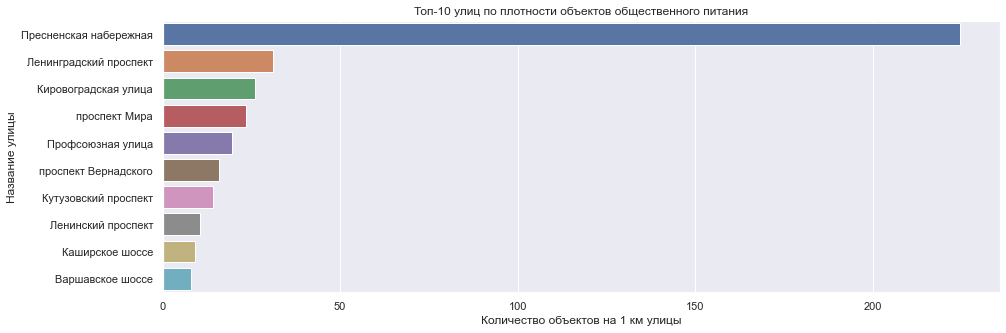

In [44]:
# постороим диаграмму
sns.barplot(x='density', y='index', data=dt1)\
    .set(title = 'Топ-10 улиц по плотности объектов общественного питания',
          xlabel = 'Количество объектов на 1 км улицы',
          ylabel = 'Название улицы',
          )
plt.show()

Подтвердилось одно из предположений, а именно: Пресненская набережная, расположенная в пределах одного района и имеющая наименьшею протяженность из улиц в топ-10, имеет значительно более высокую плотность расположения объектов. Это обусловлено расположением на ней ММДЦ «Москва-Сити». При этом необходимо отметить, что чем больше протяженность улицы, тем более неравномерно распределение объектов на нет. Так, для самого протяженного в выборке Варшавского шоссе можно утверждать, что объекты общественного питания будут сосредоточены в местах расположения ТЦ, ближе к центру и в крупных районах жилой застройки, а в местах, где шоссе проходит через промышленные территории, таких объектом может не быть.

В текущем виде таблица 'sup_dt1' в столбце 'um_te' содержит список районов через которые проходит улица. Переформатируем таблицу таким образом, что бы в строке осталась только одна пара значений 'um_namef' - 'um_te' остальнве пары допишем в конец таблицы. Для этого сначала разнесём каждое значение из 'um_te' в отдельный столбец, а затем переформатируем таблицу.

In [45]:
# функция для обработки строки.
def um_te_split (row):
    # создаем массив из номеров te
    te_list = row['um_te'].split(';')
    # перебираем элементы массива и сохраняем каждый элемент в свой столбец
    for i in range(len(te_list)):
        cl = ['um_te']
        cl.append(str(i))
        col_name = ''.join(cl)
        row[col_name] =  te_list[i]
    return row       

In [46]:
# Применяем функцию строки к sup_dt1
# Для визуализации процесса обработки используем tqdm
tqdm.pandas()
sup_dt1 = sup_dt1.progress_apply(um_te_split, axis=1)
sup_dt1.head()

100%|█████████████████████████████████████| 5324/5324 [00:17<00:00, 308.38it/s]


,te_qty,um_namef,um_te,um_te0,um_te1,um_te2,um_te3,um_te4,um_te5,um_te6,um_te7,um_te8
0,1,1-й Ирининский переулок,102,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2-й Ирининский переулок,102,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3-й Ирининский переулок,102,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Иркутская улица,406,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1-й Иртышский проезд,406,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# оставим только столбцы необходимые для дальнейшей обработки
sup_dt1 = sup_dt1.drop(['um_te'], axis = 1)

In [48]:
# приведем таблицу к виду: один код - одна улица
sup_dt2 = sup_dt1.loc[:, ['um_namef', 'um_te0']] # 'um_names'
sup_dt2.rename(columns={'um_te0': 'um_te'}, inplace=True)
for i in range(1, 9):
    col_names_list = ['um_namef'] # 'um_names'
    curr_col = ''.join(['um_te', str(i)])
    col_names_list.append(curr_col)
    dft = sup_dt1.loc[:, col_names_list]
    dft.rename(columns={ curr_col : 'um_te' }, inplace=True)
    dft = dft.dropna()
    sup_dt2 = pd.merge(sup_dt2, dft, how='outer')
# проверка    
sup_dt2.tail()

,um_namef,um_te
5999,Волгоградский проспект,0515
6000,Дмитровское шоссе,0315
6001,Ленинский проспект,0817
6002,Варшавское шоссе,0711
6003,Варшавское шоссе,1111


In [49]:
sup_dt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6004 entries, 0 to 6003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   um_namef  6004 non-null   object
 1   um_te     6004 non-null   object
dtypes: object(2)
memory usage: 140.7+ KB


Воспользуемся внешними данными с Портала открытых данных (https://data.mos.ru/).  
Общемосковский классификатор территориальных единиц Москвы (ОМК 002-2013) Раздел 1   
https://data.mos.ru/classifier/7710168515-obshchemoskovskiy-klassifikator-territorialnyh-edinits-moskvy-omk-002-2013-razdel-1?pageNumber=14&versionNumber=1&releaseNumber=5

Из этих данных мы получим названия районов и округов по коду 'um_te'

In [50]:
# Импортируем данные, предварительно загруженные на Google Диск
spreadsheet_id = '17JylBlMaVN-FSfz8mLfQpNy97QRN2GMtQiV3vlCqcLM'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
sup_dt3 = pd.read_csv(BytesIO(r.content))
sup_dt3.head()

,Kod,Name,global_id,Latin_name,Type,Kod_okato
0,100,Центральный административный округ,58703558,Czentral`ny'j administrativny'j okrug,2,45286000
1,101,район Арбат,58703559,rajon Arbat,3,45286552
2,102,Басманный район,58703560,Basmanny'j rajon,3,45286555
3,103,район Замоскворечье,58703561,rajon Zamoskvorech`e,3,45286560
4,104,Красносельский район,58703562,Krasnosel`skij rajon,3,45286565


In [51]:
# Оставляем только нужное
sup_dt3 = sup_dt3.loc[:, ['Kod', 'Name']]
sup_dt3.head()

,Kod,Name
0,100,Центральный административный округ
1,101,район Арбат
2,102,Басманный район
3,103,район Замоскворечье
4,104,Красносельский район


In [52]:
sup_dt3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Kod     158 non-null    int64 
 1   Name    158 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


Для выполнения слияния таблиц sup_dt2 и sup_dt3 по коду района, необходимо единообразия фармата дынных в чтолбце для слияния.

In [53]:
# меняем формат данных
sup_dt2['um_te'] = sup_dt2['um_te'].astype('int64')
sup_dt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6004 entries, 0 to 6003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   um_namef  6004 non-null   object
 1   um_te     6004 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.7+ KB


In [54]:
# выполним слияние
sup_dt4 = pd.merge(sup_dt2, sup_dt3, left_on='um_te', right_on='Kod', how='left')
sup_dt4.sample(5)

,um_namef,um_te,Kod,Name
4773,улица Дудинка,317,317,Ярославский район
901,Новобутовский проезд,711,711,район Южное Бутово
2937,Дачная улица,1105,1105,поселение Марушкинское
2914,Солнечная улица,1105,1105,поселение Марушкинское
2601,Садовая улица,1102,1102,поселение Воскресенское


In [55]:
# удалим ненужное и переименуем столбцы
sup_dt4 = sup_dt4.drop(['Kod'], axis = 1)
sup_dt4.rename(columns = {'um_namef':'street', 'Name':'area_name'}, inplace = True)
sup_dt4.head()

,street,um_te,area_name
0,1-й Ирининский переулок,102,Басманный район
1,2-й Ирининский переулок,102,Басманный район
2,3-й Ирининский переулок,102,Басманный район
3,Иркутская улица,406,район Гольяново
4,1-й Иртышский проезд,406,район Гольяново


Наша таблица 'sup_dt3' содержит наименования не только районов, но и более крупных АТ единиц - округов. Такие наименования имеют код вида Х00, где Х- от одного до двух символов. Выделим код округа в отдельный столбец.

In [56]:
sup_dt4['district_no'] = sup_dt4['um_te'] // 100 * 100
sup_dt4.sample(5)

,street,um_te,area_name,district_no
964,Новорублёвская улица,807,район Кунцево,800
2191,улица Хачатуряна,311,район Отрадное,300
127,улица Климашкина,106,Пресненский район,100
5910,Глебовский мост,415,район Преображенское,400
1785,Солдатский переулок,507,район Лефортово,500


In [57]:
# На основании полученных кодов добавим наименования округов, выполним слияние
sup_dt3.rename(columns = {'Kod':'district_no'}, inplace = True)
sup_dt4 = pd.merge(sup_dt4, sup_dt3, on='district_no', how='left')
sup_dt4.sample(5)

,street,um_te,area_name,district_no,Name
434,площадь Ле Зуана,712,район Ясенево,700,Юго-Западный административный округ
2846,Зелёная улица,1204,поселение Краснопахорское,1200,Троицкий административный округ
3811,1-й Рогозининский переулок,1207,поселение Первомайское,1200,Троицкий административный округ
1590,3-я улица Новые Сады,811,район Ново-Переделкино,800,Западный административный округ
818,Напольный проезд,407,район Ивановское,400,Восточный административный округ


In [58]:
sup_dt4.rename(columns = {'Name':'district_name'}, inplace = True)
sup_dt4.tail()

,street,um_te,area_name,district_no,district_name
5999,Волгоградский проспект,515,Южнопортовый район,500,Юго-Восточный административный округ
6000,Дмитровское шоссе,315,район Северный,300,Северо-Восточный административный округ
6001,Ленинский проспект,817,район Тропарёво-Никулино,800,Западный административный округ
6002,Варшавское шоссе,711,район Южное Бутово,700,Юго-Западный административный округ
6003,Варшавское шоссе,1111,поселение Щербинка,1100,Новомосковский административный округ


In [59]:
# Справочно посмотрим на самую протяжённую улицу (Варшавское шоссе) из топ-10
sup_dt4.query('street =="Варшавское шоссе"')

,street,um_te,area_name,district_no,district_name
4341,Варшавское шоссе,610,Донской район,600,Южный административный округ
5755,Варшавское шоссе,613,район Нагатино-Садовники,600,Южный административный округ
5931,Варшавское шоссе,615,Нагорный район,600,Южный административный округ
5969,Варшавское шоссе,619,район Чертаново Северное,600,Южный административный округ
5982,Варшавское шоссе,620,район Чертаново Центральное,600,Южный административный округ
5992,Варшавское шоссе,621,район Чертаново Южное,600,Южный административный округ
5998,Варшавское шоссе,708,район Северное Бутово,700,Юго-Западный административный округ
6002,Варшавское шоссе,711,район Южное Бутово,700,Юго-Западный административный округ
6003,Варшавское шоссе,1111,поселение Щербинка,1100,Новомосковский административный округ


Проходит через 9 разных районов в 3 округах.

Для справки получим таблицу с количеством районов и улиц для каждого округа.

In [60]:
total_streets = sup_dt4.groupby('district_name').agg({'area_name':'nunique', 'street':'nunique'}).reset_index()
total_streets.sort_values(by='street', ascending=False)

,district_name,area_name,street
8,Центральный административный округ,10,1094
3,Новомосковский административный округ,11,502
7,Троицкий административный округ,10,486
1,Западный административный округ,13,422
0,Восточный административный округ,16,418
4,Северный административный округ,16,375
5,Северо-Восточный административный округ,17,367
11,Южный административный округ,16,348
9,Юго-Восточный административный округ,12,343
10,Юго-Западный административный округ,12,237


Такое большое число улиц в ЦАО обусловлено, по большей части, исторической застройкой для которой характерны относительно маленькие улицы. В тоже время, для Зеленоградского АО, в частности для Зеленограда, характерно отсудчтвие привычного деления на улицы, адресация идёт по городу и дому.

In [61]:
# Добавим данные по районвм и округам в таблицу топ-10
dt2 = pd.merge(dt1, sup_dt4, left_on='index', right_on='street', how='left')
dt2

,index,street_x,te_qty,lenght,density,street_y,um_te,area_name,district_no,district_name
0,Пресненская набережная,167,1,0.744,224.46,Пресненская набережная,106,Пресненский район,100,Центральный административный округ
1,Ленинградский проспект,173,4,5.580,31.00,Ленинградский проспект,201,район Аэропорт,200,Северный административный округ
2,Ленинградский проспект,173,4,5.580,31.00,Ленинградский проспект,202,район Беговой,200,Северный административный округ
3,Ленинградский проспект,173,4,5.580,31.00,Ленинградский проспект,214,район Сокол,200,Северный административный округ
4,Ленинградский проспект,173,4,5.580,31.00,Ленинградский проспект,217,Хорошёвский район,200,Северный административный округ
5,Кировоградская улица,110,3,4.205,26.16,Кировоградская улица,619,район Чертаново Северное,600,Южный административный округ
6,Кировоградская улица,110,3,4.205,26.16,Кировоградская улица,620,район Чертаново Центральное,600,Южный административный округ
7,Кировоградская улица,110,3,4.205,26.16,Кировоградская улица,621,район Чертаново Южное,600,Южный административный округ
8,проспект Мира,204,7,8.638,23.62,проспект Мира,105,Мещанский район,100,Центральный административный округ
9,проспект Мира,204,7,8.638,23.62,проспект Мира,301,Алексеевский район,300,Северо-Восточный административный округ


In [62]:
# Число районов и округов для каждой из улиц в топ-10
dt3 = dt2.groupby('street_y').agg({'um_te':['nunique'], 'district_name':['nunique']})
dt3

,um_te,district_name
,nunique,nunique
street_y,,
Варшавское шоссе,9,3
Каширское шоссе,4,1
Кировоградская улица,3,1
Кутузовский проспект,2,1
Ленинградский проспект,4,1
Ленинский проспект,8,4
Пресненская набережная,1,1
Профсоюзная улица,6,1


In [63]:
# АО и количество в них илиц из топ-10
dt4 = dt2.groupby('district_name').agg({'index':['nunique']}).reset_index()
dt4.columns = dt4.columns.droplevel(1)
dt4.sort_values(by='index', ascending=False)

,district_name,index
5,Юго-Западный административный округ,4
6,Южный административный округ,4
0,Западный административный округ,3
4,Центральный административный округ,3
1,Новомосковский административный округ,1
2,Северный административный округ,1
3,Северо-Восточный административный округ,1


Из полученных данных видно, что однозначно ответить о принадлежности улицы, даже к такой крупной единице АТД, как округ, можно далеко не для всех улиц из топ-10. Тем не менее, видно, что преобладают ЮЗАО, ЮАО, ЗАО и ЦАО.

## Улицы с одним объектом общественного питания. Распределение по районам.

In [64]:
# Выделим в отдельную таблицу улицы на которых расположен только обин объект
df_obj_qty = data.groupby('street')['id'].count().to_frame().reset_index()
df_obj_qty = df_obj_qty.query('id == 1')
# Добавим столбцы с наименованием районов и округов
df_obj_qty = pd.merge(df_obj_qty, sup_dt4, on='street', how='left')
df_obj_qty

,street,id,um_te,area_name,district_no,district_name
0,1-й Балтийский переулок,1,201.0,район Аэропорт,200.0,Северный административный округ
1,1-й Басманный переулок,1,102.0,Басманный район,100.0,Центральный административный округ
2,1-й Басманный переулок,1,104.0,Красносельский район,100.0,Центральный административный округ
3,1-й Ботанический проезд,1,313.0,район Свиблово,300.0,Северо-Восточный административный округ
4,1-й Вешняковский проезд,1,513.0,Рязанский район,500.0,Юго-Восточный административный округ
...,...,...,...,...,...,...
652,улица Шеногина,1,906.0,район Хорошёво-Мнёвники,900.0,Северо-Западный административный округ
653,улица Шумилова,1,506.0,район Кузьминки,500.0,Юго-Восточный административный округ
654,улица Шумкина,1,418.0,район Сокольники,400.0,Восточный административный округ
655,улица Щорса,1,816.0,район Солнцево,800.0,Западный административный округ


In [65]:
# Для каждого из округов посмотрим на число районов и улиц с одним объектом
# Тут нужно поимнить, что одна улица может принадлежать нескольким районам и округам
df_obj_qty = df_obj_qty.groupby('district_name').agg({'area_name':'nunique', 'street':'nunique'})
df_obj_qty.sort_values(by='street', ascending= False)

,area_name,street
district_name,,
Центральный административный округ,10,174
Северо-Восточный административный округ,16,66
Восточный административный округ,14,64
Юго-Восточный административный округ,12,55
Северный административный округ,14,54
Западный административный округ,10,43
Юго-Западный административный округ,10,31
Южный административный округ,10,31
Северо-Западный административный округ,7,30


In [66]:
# Добавим в таблицу общее число районов и улиц (по округам)
df_obj_qty = pd.merge(df_obj_qty, total_streets, on='district_name', how='left')
df_obj_qty

,district_name,area_name_x,street_x,area_name_y,street_y
0,Восточный административный округ,14,64,16,418
1,Западный административный округ,10,43,13,422
2,Зеленоградский административный округ,1,1,5,92
3,Новомосковский административный округ,8,14,11,502
4,Северный административный округ,14,54,16,375
5,Северо-Восточный административный округ,16,66,17,367
6,Северо-Западный административный округ,7,30,8,217
7,Троицкий административный округ,9,12,10,486
8,Центральный административный округ,10,174,10,1094
9,Юго-Восточный административный округ,12,55,12,343


In [67]:
# переименуем столбцы
df_obj_qty.columns = ['district_name', 'areas', 'str', 'areas_total', 'str_total']
df_obj_qty

,district_name,areas,str,areas_total,str_total
0,Восточный административный округ,14,64,16,418
1,Западный административный округ,10,43,13,422
2,Зеленоградский административный округ,1,1,5,92
3,Новомосковский административный округ,8,14,11,502
4,Северный административный округ,14,54,16,375
5,Северо-Восточный административный округ,16,66,17,367
6,Северо-Западный административный округ,7,30,8,217
7,Троицкий административный округ,9,12,10,486
8,Центральный административный округ,10,174,10,1094
9,Юго-Восточный административный округ,12,55,12,343


In [68]:
# Добавим доли
df_obj_qty['ar_ratio'] = round(df_obj_qty['areas']/df_obj_qty['areas_total']*100, 2)
df_obj_qty['str_ratio'] = round(df_obj_qty['str']/df_obj_qty['str_total']*100, 2)
df_obj_qty.sort_values(by='str', ascending=False)

,district_name,areas,str,areas_total,str_total,ar_ratio,str_ratio
8,Центральный административный округ,10,174,10,1094,100.00,15.90
5,Северо-Восточный административный округ,16,66,17,367,94.12,17.98
0,Восточный административный округ,14,64,16,418,87.50,15.31
9,Юго-Восточный административный округ,12,55,12,343,100.00,16.03
4,Северный административный округ,14,54,16,375,87.50,14.40
1,Западный административный округ,10,43,13,422,76.92,10.19
10,Юго-Западный административный округ,10,31,12,237,83.33,13.08
11,Южный административный округ,10,31,16,348,62.50,8.91
6,Северо-Западный административный округ,7,30,8,217,87.50,13.82
3,Новомосковский административный округ,8,14,11,502,72.73,2.79


Последние три округа, по причинам описанным ранее, исключим из анализа.

In [69]:
df_obj_qty = df_obj_qty.sort_values(by='str', ascending=False).head(12-3)
df_obj_qty

,district_name,areas,str,areas_total,str_total,ar_ratio,str_ratio
8,Центральный административный округ,10,174,10,1094,100.00,15.90
5,Северо-Восточный административный округ,16,66,17,367,94.12,17.98
0,Восточный административный округ,14,64,16,418,87.50,15.31
9,Юго-Восточный административный округ,12,55,12,343,100.00,16.03
4,Северный административный округ,14,54,16,375,87.50,14.40
1,Западный административный округ,10,43,13,422,76.92,10.19
10,Юго-Западный административный округ,10,31,12,237,83.33,13.08
11,Южный административный округ,10,31,16,348,62.50,8.91
6,Северо-Западный административный округ,7,30,8,217,87.50,13.82


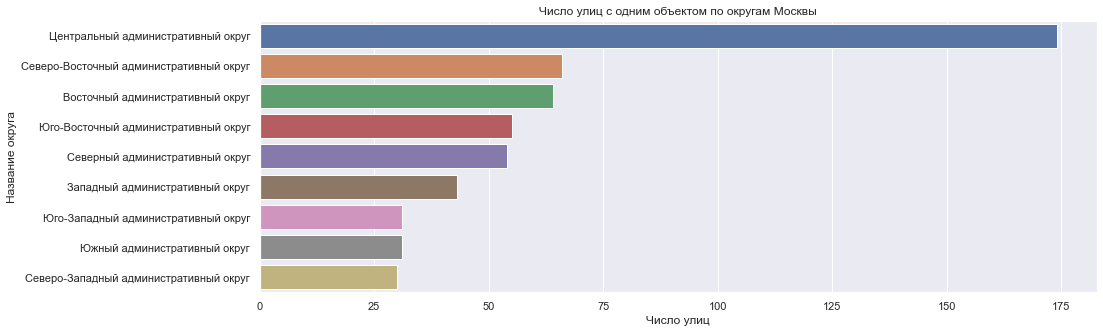

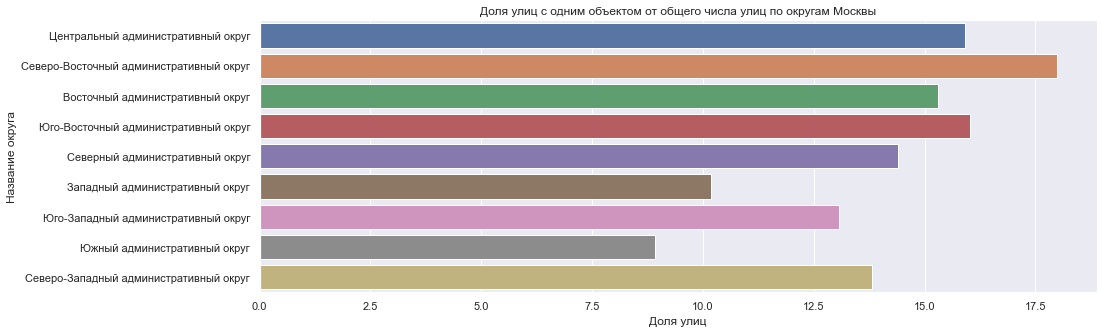

In [70]:
# постороим диаграмму по числу улиц
sns.barplot(x='str', y='district_name', data=df_obj_qty.sort_values(by='str', ascending=False))\
    .set(title = 'Число улиц с одним объектом по округам Москвы',
          xlabel = 'Число улиц',
          ylabel = 'Название округа',
          )
plt.show()
# постороим диаграмму по доле улиц
sns.barplot(x='str_ratio', y='district_name', data=df_obj_qty.sort_values(by='str', ascending=False))\
    .set(title = 'Доля улиц с одним объектом от общего числа улиц по округам Москвы',
          xlabel = 'Доля улиц',
          ylabel = 'Название округа',
          )
plt.show()

Из диаграмм видно, что наибольшее количество улиц с одним объектом общепита, в абсолютном выражении, находится в ЦАО, наименьшее - в СЗАО. В тоже время, вторая диаграмма показывает, что доля таких улиц в ЦАО меньше, чем в СВАО и ЮВАО, а СЗАО не является оутсайдером по этому показателю. Всего 8.9% улиц имеет по одному объекту общепита. Допускаем, что есть улицы без интересующих нас объектов.

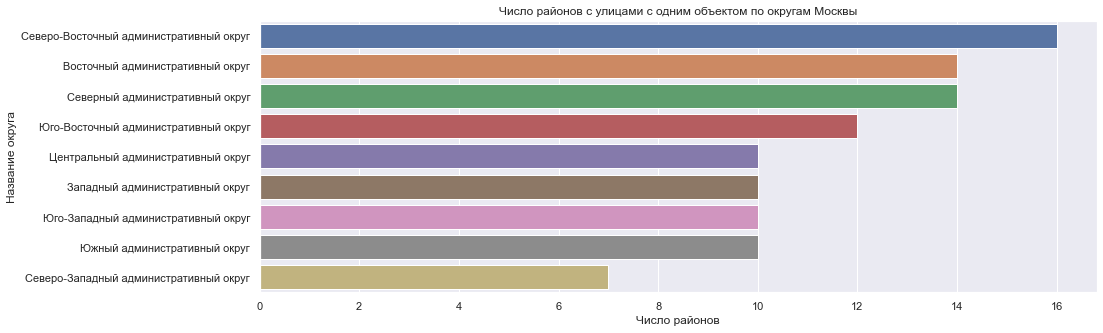

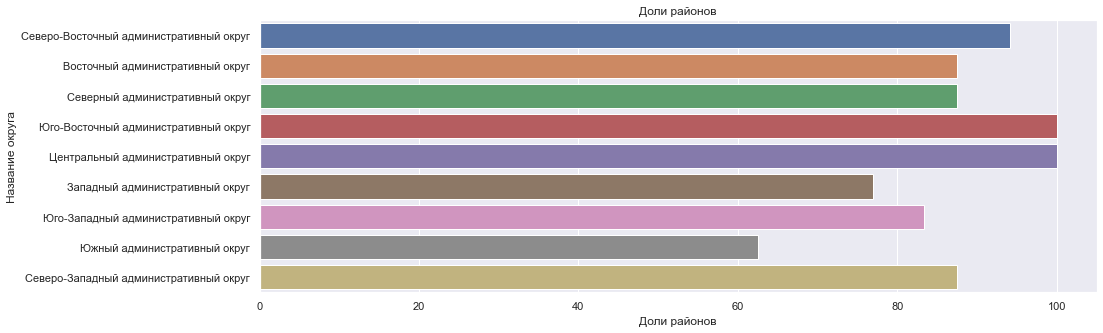

In [71]:
# постороим диаграмму по числу районов
sns.barplot(x='areas', y='district_name', data=df_obj_qty.sort_values(by='areas', ascending=False))\
    .set(title = 'Число районов с улицами с одним объектом по округам Москвы',
          xlabel = 'Число районов',
          ylabel = 'Название округа',
          )
plt.show()
# постороим диаграмму по доли районов
sns.barplot(x='ar_ratio', y='district_name', data=df_obj_qty.sort_values(by='areas', ascending=False))\
    .set(title = 'Доли районов',
          xlabel = 'Доли районов',
          ylabel = 'Название округа',
          )
plt.show()

Из диаграмм видно, что больше всего районов с улицами на которых расположен только один объект общепита в СВАО, меньше всего - в СЗАО. В тоже время, в ЮВАО и ЦАО во всех районах есть улицы на которых расположен только один объект общепита.

Для представленных выше двух групп диаграмм, необходимо отметить следующее важное замечание. Здание предполагает группировку объектов общепита по названию улицы. Как было отмечено ранее, такая группировка недостаточна для однозначного определения района и даже округа расположения объектов. Следовательно, при при более точном определении положения объектов, данные по принадлежности улиц к районам и округам будут скорректированны.

## Распределение количества посадочных мест для топ-10 улиц.

Для анализа распределения кол-ва посадочных мест для топ-10 улиц построим BoxPlot

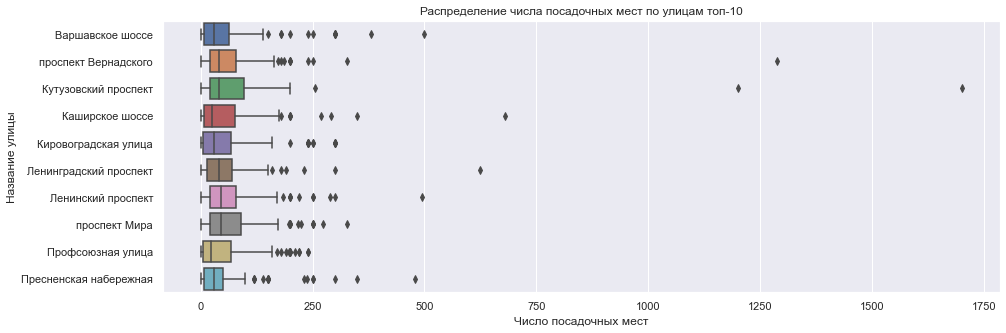

In [72]:
# Строим только для топ-10 улиц. Их список сохранён в переменной top_st_list
sns.boxplot(x='number', y='street', data=data.query('street in @top_st_list'))\
    .set(title = 'Распределение числа посадочных мест по улицам топ-10',
          xlabel = 'Число посадочных мест',
          ylabel = 'Название улицы',
        )
plt.show()

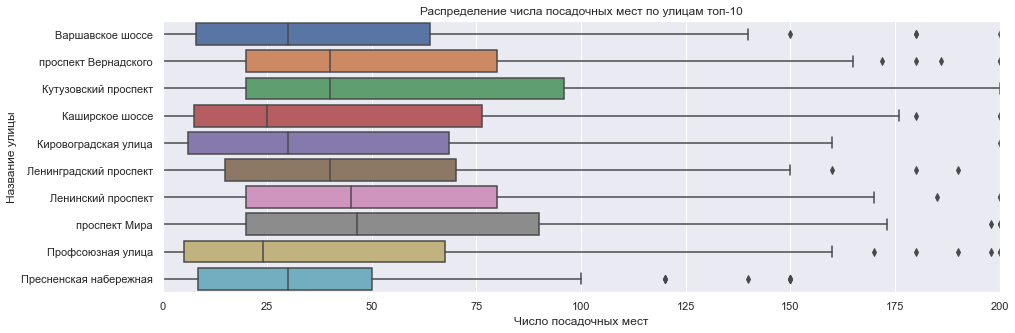

In [73]:
# Выделим зону от 0 до 200
sns.boxplot(x='number', y='street', data=data.query('street in @top_st_list'))\
    .set(title = 'Распределение числа посадочных мест по улицам топ-10',
          xlabel = 'Число посадочных мест',
          ylabel = 'Название улицы',
          xlim=(0,200)
          )
plt.show()

Помним, что для каждой из категорий объектов имеет место нулевое количество посадочных мест. Для заведений на улицах из топ-10 характерно общее число посадочных мест не более 100, с медианой не более 50. При этом для Пресненской набережной характерны небольшие заведения, а для Кутузовского пр-та самые вместительные.

# Выводы

Исходя из условий задания можно утверждать: Наиболее распространенными являются кафе несетевого типа с числом посадочных мест от 20 до 50. Больше всего объектов расположено на Проспекте Мира, но плотность значительно выше на Пресненской набережной, Ленинградском проспекте и Кировоградской улице. В рамках задания исследование проводилось по улицам. Было показано, что так как улицы могут проходить через несколько раонов и округов, то для более точного разделения объектов по районам необходимо оперировать более мелкими точным адресом (включая номер дома). 

Презентация: https://drive.google.com/file/d/10HVI80EwxLaxmEDE3a_vR_zqXaIP5exx/view?usp=sharing